In [1]:
from datasets import load_dataset
import seaborn as sns
from dotenv import load_dotenv
from juddges.settings import ROOT_PATH

In [2]:
load_dotenv(ROOT_PATH / ".env", override=True)
dataset = load_dataset("JuDDGES/nsa")

# Sample 20% of the dataset randomly
sample_size = int(len(dataset["train"]) * 0.2)
dataset["train"] = dataset["train"].shuffle(seed=17).select(range(sample_size))

Using the latest cached version of the dataset since JuDDGES/nsa couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/albert/.cache/huggingface/datasets/JuDDGES___nsa/default/0.0.0/a2c1510bb1ae9eee9f5a1953b1b7646e0ed72314 (last modified on Fri Feb 21 18:04:07 2025).


Loading dataset shards:   0%|          | 0/42 [00:00<?, ?it/s]

In [3]:
from datetime import datetime

date_column = "The day of the judgment"


def date_to_datetime(entry: dict) -> dict:
    entry[date_column] = datetime.strptime(entry[date_column], "%Y-%m-%d")
    return entry


dataset = dataset.map(date_to_datetime, num_proc=15)

ds = dataset["train"]
ds_recent = ds.filter(lambda x: x[date_column] >= datetime(2020, 1, 1))
ds = ds.map(lambda x: {"year": x[date_column].year}, num_proc=15)
ds = ds.map(lambda x: {"month": x[date_column].month}, num_proc=15)

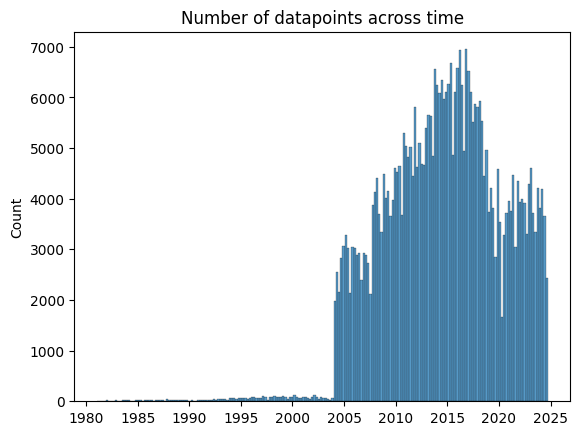

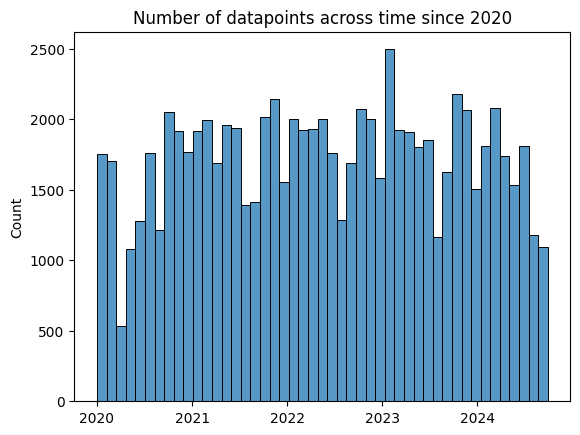

In [4]:
from matplotlib import pyplot as plt

sns.histplot(ds[date_column])
plt.title("Number of datapoints across time")
plt.show()

sns.histplot(ds_recent[date_column])
plt.title("Number of datapoints across time since 2020")
plt.show()

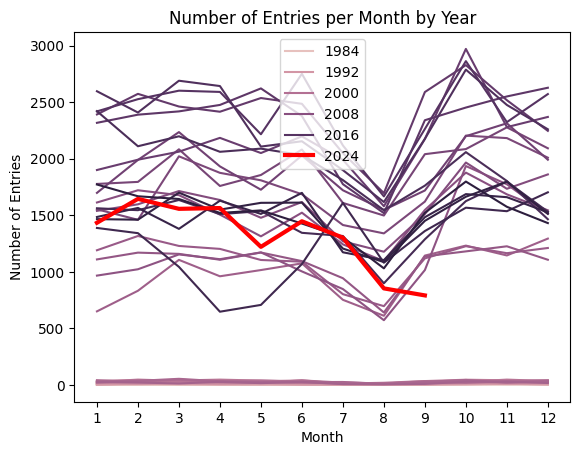

In [5]:
# Create a DataFrame and count entries per month-year combination
df = ds.to_pandas()
monthly_counts = df.groupby(["year", "month"]).size().reset_index(name="count")

# Create the line plot
g = sns.lineplot(
    data=monthly_counts[monthly_counts["year"] != 2024],  # Plot all years except 2024
    x="month",
    y="count",
    hue="year",
)

# Add 2024 line with custom style
sns.lineplot(
    data=monthly_counts[monthly_counts["year"] == 2024],
    x="month",
    y="count",
    color="red",
    linewidth=3,
    label="2024",
)

# Customize the plot
plt.xlabel("Month")
plt.ylabel("Number of Entries")
plt.title("Number of Entries per Month by Year")
plt.xticks(range(1, 13))

plt.show()

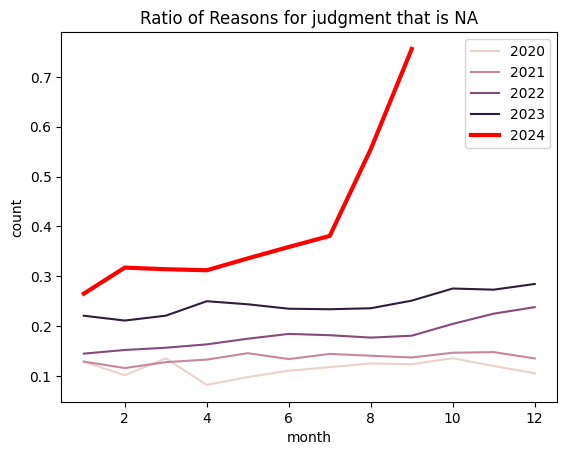

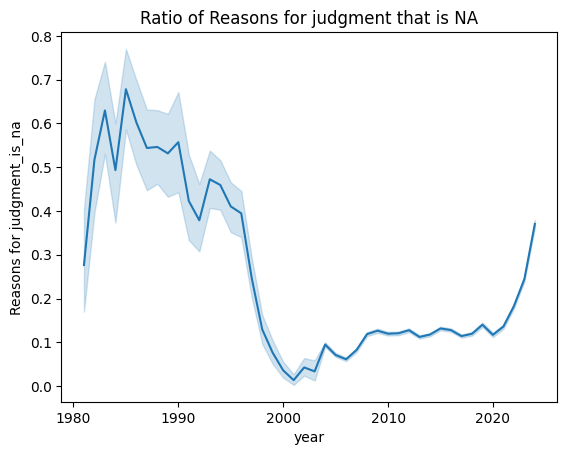

In [6]:
import pandas as pd

columns_to_examine = ["Reasons for judgment"]

for column in columns_to_examine:
    df[f"{column}_is_na"] = df[column].isna()
    monthly_counts = (
        df[df["year"] > 2019]
        .groupby(["year", "month"])[f"{column}_is_na"]
        .mean()
        .reset_index(name="count")
    )

    # Create the line plot
    ax = sns.lineplot(
        data=monthly_counts[monthly_counts["year"] != 2024],  # Plot all years except 2024
        x="month",
        y="count",
        hue="year",
    )

    # Add 2024 line with custom style
    sns.lineplot(
        data=monthly_counts[monthly_counts["year"] == 2024],
        x="month",
        y="count",
        color="red",
        linewidth=3,
        label="2024",
    )

    ax.set_title(f"Ratio of {column} that is NA")
    plt.show()

    df["YEAR_MONTH"] = df["year"].astype(str) + "_" + df["month"].astype(str)
    df["YEAR_MONTH"] = pd.to_datetime(df["YEAR_MONTH"], format="%Y_%m")

    sns.lineplot(
        data=df,
        x="year",
        y=f"{column}_is_na",
    )
    plt.title(f"Ratio of {column} that is NA")
    plt.show()

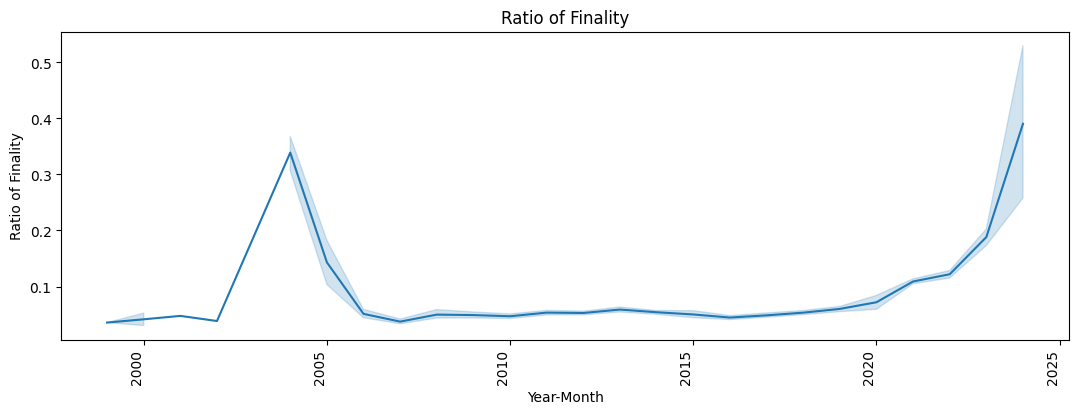

In [7]:
monthly_counts = df.groupby(["year", "month", "Finality"])["id"].count().reset_index(name="count")

monthly_counts = monthly_counts.pivot(index=["year", "month"], columns="Finality", values="count")

monthly_counts["Finality ratio"] = monthly_counts["orzeczenie nieprawomocne"] / (
    monthly_counts["orzeczenie nieprawomocne"] + monthly_counts["orzeczenie prawomocne"]
)

monthly_counts = monthly_counts.reset_index()

monthly_counts["YEAR_MONTH"] = (
    monthly_counts["year"].astype(str) + "_" + monthly_counts["month"].astype(str)
)


fig = plt.figure(figsize=(13, 4))
# Create the line plot
ax = sns.lineplot(
    data=monthly_counts,
    x="year",
    y="Finality ratio",
)

ax.set_title("Ratio of Finality")
ax.set_xlabel("Year-Month")
ax.set_ylabel("Ratio of Finality")
plt.xticks(rotation=90, ha="right")

plt.show()

1. There is increase of ratio of finality. And there is a spike in 2024. 
2. Ratio of lacking reasons is increasing from 2000. With a spike in last month before data was scraped.

What to do?
1. Reacquire datapoints with missing reasons.
2. Reacquire datapoints that are not final.
3. Do not reacquire datapoints that older than Threshold.


In [8]:
print("% of datapoints with missing reasons or not final: ")
print(
    f"{(df['Reasons for judgment_is_na'] | (df['Finality'] == 'orzeczenie nieprawomocne')).mean():.2%}"
)

% of datapoints with missing reasons or not final: 
19.17%


In [9]:
recent_df = df[df["year"] >= 2024]
print("% of datapoints with missing reasons or not final in 2024: ")
print(
    f"{(recent_df['Reasons for judgment_is_na'] | (recent_df['Finality'] == 'orzeczenie nieprawomocne')).mean():.2%}"
)

% of datapoints with missing reasons or not final in 2024: 
54.87%


## Experiment with newly acquired dataset for 01.01.2024 - 05.09.2024

### How many datapoints were in the old dataset?

In [10]:
new_df = pd.read_parquet(ROOT_PATH / "data/datasets/nsa/dataset/")
dataset = load_dataset("JuDDGES/nsa")

Using the latest cached version of the dataset since JuDDGES/nsa couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/albert/.cache/huggingface/datasets/JuDDGES___nsa/default/0.0.0/a2c1510bb1ae9eee9f5a1953b1b7646e0ed72314 (last modified on Fri Feb 21 18:04:07 2025).


Loading dataset shards:   0%|          | 0/42 [00:00<?, ?it/s]

In [11]:
olds_ids = set(dataset["train"]["id"])
new_df["was_in_old_dataset"] = new_df["id"].isin(olds_ids)
new_df["date"] = pd.to_datetime(new_df["judgment_date"])
new_df = new_df[new_df["date"].dt.month < 9]

In [12]:
print(
    f"% of datapoints that were not in the old dataset: {(~new_df['was_in_old_dataset']).mean():.2%}"
)

% of datapoints that were not in the old dataset: 9.69%


<Axes: xlabel='date', ylabel='was_in_old_dataset'>

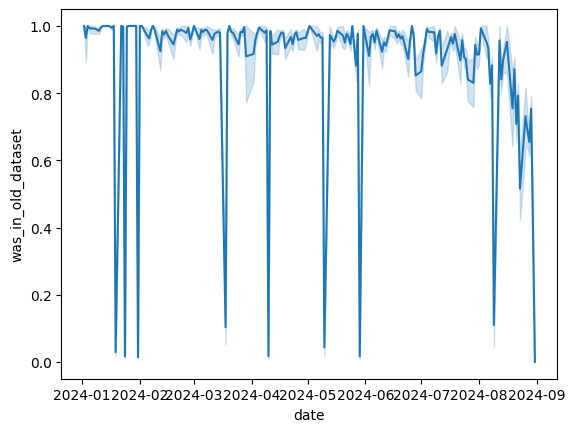

In [13]:
sns.lineplot(data=new_df, x="date", y="was_in_old_dataset")

In [14]:
new_df["month"] = new_df["date"].dt.month
new_df["year"] = new_df["date"].dt.year

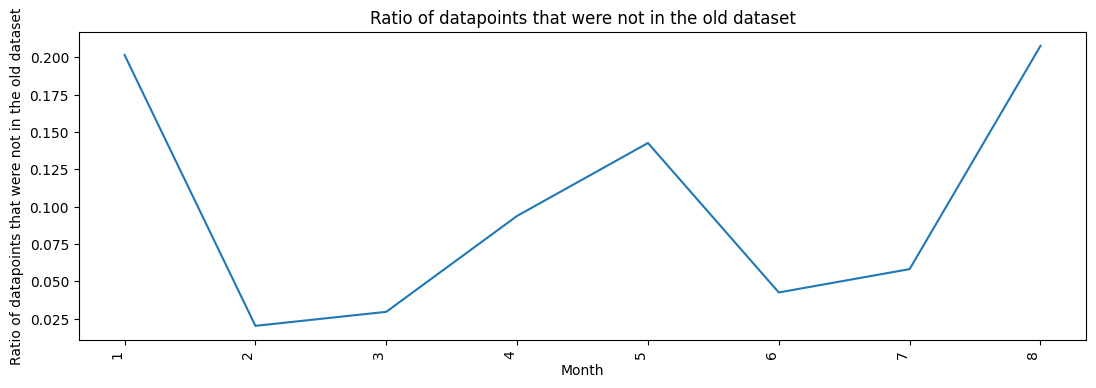

In [15]:
monthly_counts = (
    new_df.groupby(["year", "month", "was_in_old_dataset"])["id"].count().reset_index(name="count")
)

monthly_counts = monthly_counts.pivot(index=["month"], columns="was_in_old_dataset", values="count")

monthly_counts["ratio"] = monthly_counts[False] / (monthly_counts[False] + monthly_counts[True])

monthly_counts = monthly_counts.reset_index()


fig = plt.figure(figsize=(13, 4))
# Create the line plot
ax = sns.lineplot(
    data=monthly_counts,
    x="month",
    y="ratio",
)

ax.set_title("Ratio of datapoints that were not in the old dataset")
ax.set_xlabel("Month")
ax.set_ylabel("Ratio of datapoints that were not in the old dataset")
plt.xticks(rotation=90, ha="right")

plt.show()

### How many OLD datapoints were in the NEW dataset?

In [16]:
dataset = load_dataset("JuDDGES/nsa")

date_column = "The day of the judgment"
dataset = dataset.filter(lambda x: x[date_column].startswith("2024-"), num_proc=15)


def date_to_datetime(entry: dict) -> dict:
    entry[date_column] = datetime.strptime(entry[date_column], "%Y-%m-%d")
    return entry


dataset = dataset.map(date_to_datetime, num_proc=15)
ds = dataset["train"]
ds = ds.map(lambda x: {"year": x[date_column].year}, num_proc=15)
ds = ds.map(lambda x: {"month": x[date_column].month}, num_proc=15)
ds = ds.filter(lambda x: x["month"] < 9, num_proc=15)

Using the latest cached version of the dataset since JuDDGES/nsa couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/albert/.cache/huggingface/datasets/JuDDGES___nsa/default/0.0.0/a2c1510bb1ae9eee9f5a1953b1b7646e0ed72314 (last modified on Fri Feb 21 18:04:07 2025).


Loading dataset shards:   0%|          | 0/42 [00:00<?, ?it/s]

In [17]:
df = ds.to_pandas()
df["is_in_new_dataset"] = df["id"].isin(set(new_df["id"]))

In [18]:
print(f"% of datapoints that are not in the new dataset: {(~df['is_in_new_dataset']).mean():.2%}")

% of datapoints that are not in the new dataset: 2.69%


In [19]:
df[date_column].sort_values()

39923   2024-01-02
37166   2024-01-02
9319    2024-01-02
23196   2024-01-02
31036   2024-01-02
           ...    
826     2024-08-30
4533    2024-08-30
651     2024-08-30
24646   2024-08-30
49310   2024-08-30
Name: The day of the judgment, Length: 55177, dtype: datetime64[us]

In [20]:
new_df["date"].sort_values()

47918   2024-01-02
45182   2024-01-02
43728   2024-01-02
1737    2024-01-02
33718   2024-01-02
           ...    
54222   2024-08-31
60097   2024-08-31
44575   2024-08-31
9692    2024-08-31
58938   2024-08-31
Name: date, Length: 59448, dtype: datetime64[ns]

In [21]:
df.groupby(["is_in_new_dataset", "month"])["id"].count().reset_index(name="count")

,is_in_new_dataset,month,count
0,False,1,295
1,False,2,3
2,False,3,572
3,False,4,4
4,False,5,8
5,False,6,590
6,False,7,3
7,False,8,12
8,True,1,6677
9,True,2,8176


### Do Reasons and finality change?

In [22]:
print("Year 2024")
print(f"% of datapoints with missing reasons: {df['Reasons for judgment'].isna().mean():.2%}")
print(
    f"% of datapoints that are not final: {(df['Finality'] == 'orzeczenie nieprawomocne').mean():.2%}"
)

Year 2024
% of datapoints with missing reasons: 33.63%
% of datapoints that are not final: 30.54%


In [23]:
ids = df[df["Reasons for judgment"].isna() & df["id"].isin(set(new_df["id"]))]["id"]

print(
    f"% of datapoints with changed reasons: {1 -new_df[new_df['id'].isin(ids)]['reasons'].isna().mean():.2%}"
)

% of datapoints with changed reasons: 17.44%


In [24]:
new_df[new_df["id"].isin(ids)][~new_df[new_df["id"].isin(ids)]["reasons"].isna()].head(2)

,id,docket_no,decision_type,finality,judgment_date,submission_date,court,judges,presiding_judge,rapporteur,...,published_in_collection,glosa_info,theses,sentence,reasons,dissenting_opinion,was_in_old_dataset,date,month,year
72,/doc/39457A5C4B,III FSK 1686/23,Wyrok NSA,orzeczenie prawomocne,2024-07-24,2023-12-28,Naczelny Sąd Administracyjny,"[Jacek Brolik, Jolanta Sokołowska, Krzysztof P...",Jacek Brolik,Jacek Brolik,...,NaN,NaN,None,Naczelny Sąd Administracyjny w składzie: Przew...,Zaskarżonym wyrokiem z 7 września 2023 r. (syg...,None,True,2024-07-24,7,2024
83,/doc/9CD725A892,II OZ 428/24,Postanowienie NSA,orzeczenie prawomocne,2024-08-27,2024-07-10,Naczelny Sąd Administracyjny,[Tomasz Bąkowski],Tomasz Bąkowski,Tomasz Bąkowski,...,NaN,NaN,None,Naczelny Sąd Administracyjny w składzie: Przew...,Przewodnicząca Wydziału II Wojewódzkiego Sądu ...,None,True,2024-08-27,8,2024


In [25]:
display(df[df["id"] == "/doc/39457A5C4B"]["Reasons for judgment"])
display(new_df[new_df["id"] == "/doc/39457A5C4B"]["reasons"])

45671    None
Name: Reasons for judgment, dtype: object

72    Zaskarżonym wyrokiem z 7 września 2023 r. (syg...
Name: reasons, dtype: object

In [26]:
df["Finality"].value_counts()

Finality
orzeczenie prawomocne       37420
orzeczenie nieprawomocne    16851
Name: count, dtype: int64

In [27]:
ids = df[(df["Finality"] == "orzeczenie nieprawomocne") & df["id"].isin(set(new_df["id"]))]["id"]
df_ = new_df[new_df["id"].isin(ids)]
x = (df_["finality"] != "orzeczenie nieprawomocne").mean()

print(f"% of datapoints with changed finality: {x:.2%}")

% of datapoints with changed finality: 34.14%


In [28]:
df_[df_["finality"] != "orzeczenie nieprawomocne"].head(2)

,id,docket_no,decision_type,finality,judgment_date,submission_date,court,judges,presiding_judge,rapporteur,...,published_in_collection,glosa_info,theses,sentence,reasons,dissenting_opinion,was_in_old_dataset,date,month,year
1,/doc/F9FAF349CB,III SA/Kr 303/24,Postanowienie WSA w Krakowie,orzeczenie prawomocne,2024-04-02,2024-03-07,Wojewódzki Sąd Administracyjny w Krakowie,[Renata Czeluśniak],Renata Czeluśniak,Renata Czeluśniak,...,NaN,NaN,None,Wojewódzki Sąd Administracyjny w Krakowie w sk...,Dyrektor Małopolskiego Oddziału Regionalnego A...,None,True,2024-04-02,4,2024
8,/doc/0ADACF8213,I SA/Wr 830/23,Wyrok WSA we Wrocławiu,orzeczenie prawomocne,2024-04-02,2023-10-05,Wojewódzki Sąd Administracyjny we Wrocławiu,[Jarosław Horobiowski],Jarosław Horobiowski,Jarosław Horobiowski,...,NaN,NaN,None,Wojewódzki Sąd Administracyjny we Wrocławiu w ...,1. Postępowanie przed organem podatkowym.\n\n1...,None,True,2024-04-02,4,2024


In [29]:
display(df[df["id"] == "/doc/F9FAF349CB"]["Finality"])
display(new_df[new_df["id"] == "/doc/F9FAF349CB"]["finality"])

16535    orzeczenie nieprawomocne
Name: Finality, dtype: object

1    orzeczenie prawomocne
Name: finality, dtype: object